# Entity extraction on Financial Complaints with Watson NLP

This notebook demonstrates how to extract _named entities_ from financial customer complaints using Watson NLP.

The data that is used in this notebook is taken from the Consumer Complaint Database that is published by the Consumer Financial Protection Bureau (CFPB), an U.S. government agency. The Consumer Complaint Database is a collection of complaints about consumer financial products and services that the CFPB sent to companies for response.  A complaint contains a consumer’s narrative description of their experience if the consumer opts to share this information publicly and after the CFPB has taken steps to remove all personal information. In this notebook, you will focus on complaints that contain narrative descriptions to show how to use Watson NLP.

The data is publicly available at https://www.consumerfinance.gov/data-research/consumer-complaints/.

## What you'll learn in this notebook

Watson NLP offers so-called blocks for various NLP tasks. This notebooks shows:

- **Dictionary-based term extraction** with the _Rule-based extractor_ provided by `watson_nlp.resources.feature_extractor.RBR`. This allows you to train a custom extraction model based on given dictionaries.

- **Entity extraction** with the _Entity mentions workflow_ using the transformer-based model. This workflow extracts mentions of entities like *Persion*, *Organization* or *Duration* from the input text.


## Table of Contents

1. [Before you start](#beforeYouStart)
2. [Load the complaints](#loadData)
3. [Custom term extraction using dictionaries](#dictionaries)
4. [Entity extraction](#entities)
5. [Summary](#summary)

<a id="beforeYouStart"></a>
## Before you start

You can step through the notebook execution cell by cell, by selecting Shift-Enter or you can execute the entire notebook by selecting **Cell -> Run All** from the menu. 

**Note:** If you have other notebooks currently running with the _NLP_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.


Begin by importing and initializing some helper libraries that are used throughout the notebook.

In [2]:
import os
import json
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

In [3]:
import watson_nlp

Detect if the notebook is running in a CPU- or GPU-based environment. Depending on this information, you may load GPU- or CPU-optimized NLP models for sentiment and targets sentiment extraction.

In [4]:
gpu_available = False
try:
    hw_spec = os.environ['RUNTIME_HARDWARE_SPEC']
    if 'num_gpu' in json.loads(hw_spec):
        gpu_available = True
except:
    pass

<a id="loadData"></a>
## Load the complaints

The data can be downloaded via an API from https://www.consumerfinance.gov/data-research/consumer-complaints/. For this notebook, the complaints for one month will be downloaded and only those that contain the consumer narrative text. The data is exported in CSV format. The URL to retrieve this data is:

In [5]:
url = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2021-03-30&date_received_min=2021-02-28&field=all&format=csv&has_narrative=true&no_aggs=true&size=18102"

Read the data into a dataframe.

You can find a detailed explanation of the available columns here: https://www.consumerfinance.gov/complaint/data-use/#:~:text=Types%20of%20complaint%20data%20we%20publish .

In the analysis, you will focus on the *Product* column and the column with the complaint text *Consumer complaint narrative*.

In [6]:
df_all = pd.read_csv(url)
text_col = 'Consumer complaint narrative'

# In this example, we take only the first 1000 complaints in the dataset for further analysis. 
# Set df to df_all to run on the complete dataset.
df_small = df_all.head(1000)
df = df_small
df.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/16/21,Mortgage,Other type of mortgage,Closing on a mortgage,NaN,I have spoken with the representative for guaranteed rate with no positive results. this company was very negligent and handling my loan process which called me to lose XXXX and to lose the home that I was trying to purchase. they would wait until the day of clothes or one day before close and continue to ask for a documentation that I sent in to them every single time. They would wait 3 to 4 ...,NaN,GUARANTEED RATE INC.,GA,30233,NaN,Consent provided,Web,03/16/21,Closed with explanation,Yes,NaN,4217655
1,03/23/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Problem with a credit reporting company's investigation into an existing problem,Their investigation did not fix an error on your report,"Im submitting this complaint against EQUIFAX due to their total disregard for my consumer rights under the FCRA/FCBA/FDCPA. For several months now, I've been disputing inaccurate and unverifiable information showing up on my credit report by this company. I have requested intimate information about the alleged accounts, including a copy of an agreement with my signature on it, but I have yet t...",NaN,"EQUIFAX, INC.",TX,77449,NaN,Consent provided,Web,03/23/21,Closed with explanation,Yes,NaN,4240468
2,03/23/21,"Money transfer, virtual currency, or money service",Mobile or digital wallet,Fraud or scam,NaN,"I was approached by a family member about lending them some money through XXXX on Chase, When i went to my bank it had already been sent from my account to a "" manny '' with an account linked by the phone number XXXX XXXX XXXX XXXX, They sent themselves 2 payments, one of {$350.00} and another for {$500.00} I contacted my family member right away and they confirmed that someone had assumed the...",NaN,JPMORGAN CHASE & CO.,CA,94116,NaN,Consent provided,Web,03/23/21,Closed with explanation,Yes,NaN,4237488


You can look at all products that are available in the data set to do further analysis around these product groups.

<Axes: ylabel='Product'>

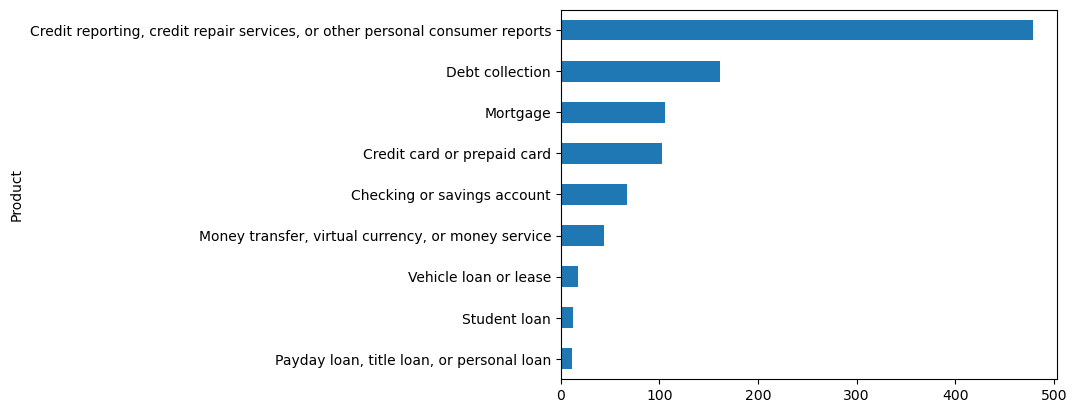

In [7]:
df['Product'].value_counts().sort_values().plot(kind='barh') 

<a id="dictionaries"></a>
## Custom term extraction using dictionaries

If you want to extract custom concepts via rule-based extraction, you can build a custom RBR model using an AQL model. However this requires knowledge of AQL. If you just want to extract custom terms or match regular expression patterns, there is a convenient way to train and run such models through `watson_nlp.resources.feature_extractor.RBR`. You only need to provide your own dictionaries or regexes and it trains an RBR model for you.

You will now create a basic dictionary that contains terms that might indicate customers suspecting a fraud concerning their financial products like the theft of a credit card.

Start with creating a folder that holds all dictionary files that you want to use for extraction.

In [8]:
import os
RBR_dicts_folder = "RBR_dicts"
os.makedirs(RBR_dicts_folder, exist_ok=True)

A dictionary can contain the dictionary terms as a flat list if all the terms are to be mapped to the same label. Alternatively, you can use a mapping dictionary that maps terms to a label. 

In this notebook, you will create a dictionary mapping file containing the fraud-related terms divided into *FRAUD* and *THEFT*. Each line has one dictionary entry.

In [9]:
fraud_file = "fraud_mappings.csv"
with open(os.path.join(RBR_dicts_folder, fraud_file), 'w') as dict:
    dict.write("\"label\", \"entry\"\n")
    dict.write("\"FRAUD\", \"fraud\"\n")
    dict.write("\"FRAUD\", \"takeover\"\n")
    dict.write("\"FRAUD\", \"skimming\"\n")
    dict.write("\"FRAUD\", \"phishing\"\n")
    dict.write("\"THEFT\", \"theft\"\n")
    dict.write("\"THEFT\", \"thief\"\n")
    dict.write("\"THEFT\", \"thieve\"\n")
    dict.write("\"THEFT\", \"steal\"\n")

In the next step, load the file as dictionary. The source dictionary path is a relative path to the created dictionary resources folder. You will use case-insensitive matching as the dictionary entries are regular words that are not likely to be miss-interpreted.

Lemma-matching will make sure that inflections of the dictionary entries will also match, for example, "steal" -> "stole", "stolen", "stealing".

In [10]:
from watson_nlp.toolkit.rule_utils import DictionaryConfig

dictionary = DictionaryConfig.load( 
    {
        'name': 'fraud_mappings',
        'source': fraud_file,
        'dict_type': 'table',
        'case': 'insensitive',
        'lemma': True,
        'mappings': {
            'columns': ['label', 'entry'],
            'entry': 'entry'
        }
    }
)

Train the RBR model using the created dictionary. This will create the unterlying AQL code.

In [11]:
trained_dict_RBR = watson_nlp.resources.feature_extractor.RBR.train(RBR_dicts_folder, language='en', dictionaries=[dictionary,])

As for the other demonstrated blocks before, create a helper method to run the RBR model on a single complaint. There is a `run()` method on the trained model, which returns the extracted concept and the span specifying the covered text.
But as you also want to see the covered text immediatly, you will access the raw response from the underlying RBR executor.

In [12]:
def extract_dictionary(complaint_text):
    RBR_result = trained_dict_RBR.executor.get_raw_response(complaint_text, language='en')
    # aggregate all matches into one array with the match label and the text evidence
    matches = []
    for view in RBR_result['annotations'].keys():
        for dict_match in RBR_result['annotations'][view]:
            matches.append(tuple((dict_match['label'], dict_match['match']['text'])))
    return matches

Now run the dictionary extraction on the complete dataframe and display the results with the complaint text.

In [13]:
# run dictionary extraction and create a dataframe holding the results
dict_matches = df[text_col].apply(lambda text: extract_dictionary(text))
dict_matches_df = pd.DataFrame(dict_matches)
dict_matches_df.rename(inplace=True, columns={text_col:'Fraud Indicators'})
# combine with the complaint dataframe
text_dict_matches_df = df[["Product", text_col]].merge(dict_matches_df, how='left', left_index=True, right_index=True)
text_dict_matches_df.head(10)

,Product,Consumer complaint narrative,Fraud Indicators
0,Mortgage,I have spoken with the representative for guaranteed rate with no positive results. this company was very negligent and handling my loan process which called me to lose XXXX and to lose the home that I was trying to purchase. they would wait until the day of clothes or one day before close and continue to ask for a documentation that I sent in to them every single time. They would wait 3 to 4 ...,[]
1,"Credit reporting, credit repair services, or other personal consumer reports","Im submitting this complaint against EQUIFAX due to their total disregard for my consumer rights under the FCRA/FCBA/FDCPA. For several months now, I've been disputing inaccurate and unverifiable information showing up on my credit report by this company. I have requested intimate information about the alleged accounts, including a copy of an agreement with my signature on it, but I have yet t...",[]
2,"Money transfer, virtual currency, or money service","I was approached by a family member about lending them some money through XXXX on Chase, When i went to my bank it had already been sent from my account to a "" manny '' with an account linked by the phone number XXXX XXXX XXXX XXXX, They sent themselves 2 payments, one of {$350.00} and another for {$500.00} I contacted my family member right away and they confirmed that someone had assumed the...","[(FRAUD, fraud), (FRAUD, fraud)]"
3,"Credit reporting, credit repair services, or other personal consumer reports","Hello, In XXXX oXXXX XXXX, I filed a dispute with the credit bureaus about the illegally reinserted collection account : XXXX XXXX account # XXXX I did some reading about credit reporting laws and under the FCRA ( A ) ( 5 ) ( B ), all reinserted accounts must be given a five day notice from the credit bureaus or it must be promptly deleted. and from my understanding if a consumer finds errors ...",[]
4,Checking or savings account,"Navy Federal has made it impossible to access my money but VERY easy to deposit. I had direct deposit with Navy Fed where I also have stimulus checks deposited. They locked me out of accessing my acct online and only can access by calling or going in person. However because in Texas it has been impossible to renew drivers licenses because of XXXX, I have not been able to access in person eithe...","[(FRAUD, fraud)]"
5,"Credit reporting, credit repair services, or other personal consumer reports",I have filed a dispute in regards to the incorrect items on my credit report. It has been well over 30 days and I haven't received any investigation results.,[]
6,"Credit reporting, credit repair services, or other personal consumer reports",First progress reported this account closed XX/XX/2018. Yet first progress is reporting payment history on top of that every month As a chargeoff. This is a violation!!! Fcra indicates that information must report with accuracy and this is accurate? My score has been drastically affected,[]
7,Checking or savings account,"I spoke with a Citibank representative over the phone on Saturday XX/XX/2021, and explained that I had a check drawn off Citibank account and inquired on availability. I was told that funds we be available Tuesday Morning XXXX XXXX. I deposited the check on Saturday XX/XX/2021 and included a cash deposit. The available balance was {$340.00} which would cover any purchases. However on Tuesday X...",[]
8,Debt collection,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX DISCLOSURE : THIS IS NOT AN IDENTITY THEFT DISPUTE, PLEASE REFRAIN FROM TAKING ANY POSITION OF IDENTITY THEFT EITHER WITH ANY CREDIT REPORTING AGENCY O...","[(THEFT, THEFT), (THEFT, THEFT), (THEFT, theft), (FRAUD, fraud), (THEFT, THEFT), (THEFT, THEFT)]"
9,Debt collection,"I XXXX XXXX XXXX have reque

Notice that "stolen" was detected as *THEFT* as the base-form *steal* is contained in the dictionary and you used lemma-matching.

How many complaints talk about *THEFT* or *FRAUD* or both? Count the complaints for each product group and display the relative frequency: 

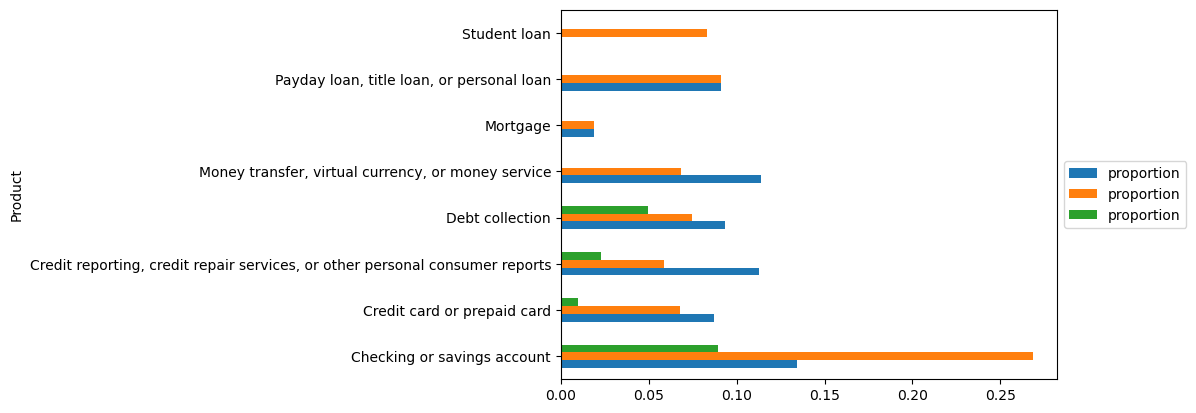

In [14]:
# create a column indicating if the complaint contains at least one *FRAUD* or *THEFT* match
text_dict_matches_df['THEFT'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'THEFT' in set([match[0] for match in matches]))
text_dict_matches_df['FRAUD'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'FRAUD' in set([match[0] for match in matches]))
text_dict_matches_df['BOTH'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'FRAUD' in set([match[0] for match in matches]) and 'THEFT' in set([match[0] for match in matches]))

# get the relative frequency by product group
perc_theft = text_dict_matches_df.groupby('Product')['THEFT'].value_counts(normalize=True)
perc_fraud = text_dict_matches_df.groupby('Product')['FRAUD'].value_counts(normalize=True)
perc_both = text_dict_matches_df.groupby('Product')['BOTH'].value_counts(normalize=True)
# combine the values into one dataframe
res = pd.concat([perc_theft, perc_fraud, perc_both], axis=1).reset_index().rename(columns={"level_1": "is_contained"})
# only use the counts for rows indicating a match
res = res[res['is_contained']].drop('is_contained', axis=1).set_index('Product')
res.plot.barh().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


More than 10% of the Money transfer/service complaints seem to deal with theft and over 25% of the checking or savings account complaints with fraud.

<a id="entities"></a>
## Entity extraction

The complaints contain a lot of entity mentions about entities like organizations, money, durations, etc. In this section you will learn how to use the entity mention extraction workflow, which extracts entity mentions out-of-the-box. 

Start with loading the entity mentions workflow model. If the notebook is running in a CPU-based environment, the CPU-optimized entity extraction model is loaded. The GPU model may used for both GPUs and CPUs, but it is slower on CPU-based runtimes.

In [15]:
if gpu_available:
    entity_transformer_model = watson_nlp.load('entity-mentions_transformer-workflow_multilingual_slate.153m.distilled')
else:
    entity_transformer_model = watson_nlp.load('entity-mentions_transformer-workflow_multilingual_slate.153m.distilled-cpu')    

The helper method first runs the entity extraction model and returns pairs of the type and the text of extracted entities:

In [16]:
def extract_entities(complaint_text):
    entity_mentions = entity_transformer_model.run(complaint_text, 'en')
    # get text and type of entities
    entities = entity_mentions.get_mention_pairs()
    return entities

Run the entity extraction model on the complaint dataframe and show the extracted entities along with the complaint text.<br/> **Note:** This cell will run for several minutes. For better progress feedback, the cell is using `progress_apply` from the `tqdm` library. You can also use `apply` from `pandas` directly, i.e. `df[text_col].apply(..)`

In [17]:
from tqdm.notebook import tqdm
tqdm.pandas(colour='green')

In [ ]:
# run entity extraction and create a dataframe holding the results
entities = df[text_col].progress_apply(lambda text: extract_entities(text))
entities_df = pd.DataFrame(entities)
entities_df.rename(inplace=True, columns={text_col:'Entities'})
# combine with our complaint dataframe
text_entities_df = df[["Product", text_col]].merge(entities_df, how='left', left_index=True, right_index=True)
text_entities_df.head()

Let's see what kind of entities are extracted from the complaints:

In [ ]:
# helper method to extract the mention type from the (text, type) tuple
def get_entity_type(ent):
    if not pd.isna(ent):
        return ent[1]
    return 'None'

# create separate rows for each entity mention
exp_entities = text_entities_df.explode('Entities')
# extract the entity type of each mention
exp_entities['Entity Type'] = exp_entities['Entities'].apply(lambda ent: get_entity_type(ent))
# count the number of occurrences for each entity type
exp_entities['Entity Type'].value_counts().head(20).sort_values().plot(kind='barh') 

Show the relative frequency of each entity type by product:

In [ ]:
unstacked = exp_entities.groupby('Product')['Entity Type'].value_counts(normalize=True).unstack()
unstacked.plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

*Job Titles* are frequently mentioned in the *Vechicle loan or lease* product group and there is a high number of *Location* mentions for the product group *Debt collection*. Let's look at some sample texts for the job titles:

In [ ]:
exp_entities.query('`Entity Type` == "JobTitle" and Product == "Vehicle loan or lease"').head()

<a id="summary"></a>
## Summary

This notebook shows you how to use the Watson NLP library and how quickly and easily you can get started with Watson NLP by running the pretrained model for entity extraction. You learned how easy you can extract custom terms using dictionaries.

### Authors
Simone Zerfass IBM, Germany

Alexander Lang IBM, Germany

# <hr>
Copyright © 2021-2024 IBM. This notebook and its source code are released under the terms of the MIT License.